In [135]:
# # @title Data Reading and processing
# import pandas as pd
# import os
# from pandas import ExcelFile
# import matplotlib.pyplot as plt
# import seaborn as sns
# from random import sample
# import numpy as np


# df1 = pd.read_excel('/content/drive/MyDrive/MITResearch/IBD_13/IBDTr_FC_1_UMCG.xlsx')
# df2 = pd.read_excel('/content/drive/MyDrive/MITResearch/IBD_13/IBDTr_FC_2_UMCG.xlsx')
# df3_4 =pd.read_excel( '/content/drive/MyDrive/MITResearch/IBD_13/IBDTr_FC_3_4_UMCG.xlsx')
# df5 = pd.read_excel('/content/drive/MyDrive/MITResearch/IBD_13/IBDTr_FC_5_UMCG.xlsx')
# df6 = pd.read_excel('/content/drive/MyDrive/MITResearch/IBD_13/IBDTr_FC_6_UMCG.xlsx')
# df7 = pd.read_excel('/content/drive/MyDrive/MITResearch/IBD_13/IBDTr_FC_7_UMCG.xlsx')

In [136]:
# @title Simplify column names
def simplify_column_names(df):
    """
    Simplifies column names by keeping only the last part (species level) of the bacteria names.

    Parameters:
    df (pd.DataFrame): The dataframe with complex bacterial taxonomy names.

    Returns:
    pd.DataFrame: The dataframe with simplified column names.
    """
    new_columns = []
    for col in df.columns:
        if col.startswith('k__'):  # Check if the column name is a bacterial taxonomy
            # Split by semicolon and take the last part
            new_columns.append(col.split(';')[-1])
        else:
            new_columns.append(col)  # Keep the column name as is for non-bacterial columns

    df.columns = new_columns
    return df

In [137]:
# @title split patient_ids

def split_patient_ids(df):
    """
    Splits 'patientIDs' column into 'patient_id' and 'week' columns, removes the original 'patientIDs' column,
    and rearranges the new columns to appear first, efficiently.

    Parameters:
    df (pd.DataFrame): The dataframe containing the 'patientIDs' column.

    Returns:
    pd.DataFrame: The dataframe with the new 'patient_id' and 'week' columns added at the beginning,
                  and the frame reassembled efficiently to avoid fragmentation.
    """
    # Split and create new DataFrame with new columns
    new_cols = df['patientIDs'].str.extract(r'TR_(\d+)_W(\d+)')
    new_cols.columns = ['patient_id', 'week']

    # Convert types
    new_cols['patient_id'] = new_cols['patient_id']
    new_cols['week'] = new_cols['week'].astype(int)

    # Drop the original 'patientIDs' column and concatenate new columns at the front
    df.drop('patientIDs', axis=1, inplace=True)
    df = pd.concat([new_cols, df], axis=1)

    return df

In [138]:
# @title analyze_representation_and_variation function

def analyze_representation_and_variation(df, start_col, category_name):
    """
    Function to calculate mean and standard deviation for categories in a DataFrame,
    and plot the top 10 most represented and most variable categories.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    start_col (int): Column index from which to start the analysis.
    category_name (str): Name of the category (e.g., 'Bacteria', 'Genes') for labeling purposes.
    """

    # Calculate mean and standard deviation for each category
    category_mean = df.iloc[:, start_col:].mean()
    category_std = df.iloc[:, start_col:].std()

    # Identify the most represented categories (highest mean)
    most_represented = category_mean.sort_values(ascending=False).head(10)

    # Identify categories with the most variation (highest standard deviation)
    most_variable = category_std.sort_values(ascending=False).head(10)

    # Plotting
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    sns.barplot(x=most_represented.values, y=most_represented.index)
    plt.title(f'Top 10 Most Represented {category_name}')
    plt.xlabel(f'Mean Relative Abundance for {category_name}')

    plt.subplot(1, 2, 2)
    sns.barplot(x=most_variable.values, y=most_variable.index)
    plt.title(f'Top 10 {category_name} with Most Variation')
    plt.xlabel(f'Standard Deviation of Relative Abundance for {category_name}')

    plt.tight_layout()
    plt.show()


In [ ]:
# @title calculate_alpha_diversity function

def calculate_alpha_diversity(df, diversity_index='shannon'):
    """Calculate alpha diversity based on the specified diversity index."""
    if diversity_index == 'shannon':
        return df.apply(lambda x: entropy(x[x > 0]), axis=1)
    elif diversity_index == 'simpson':
        def simpson_index(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            p = x / x.sum()
            return 1 - np.sum(p**2)
        return df.apply(simpson_index, axis=1)
    elif diversity_index == 'richness':
        return df.apply(lambda x: (x > 0).sum(), axis=1)
    elif diversity_index == 'evenness':
        # Calculate evenness using Pielou's evenness index
        def pielou_evenness(x):
            x = x[x > 0]
            if len(x) == 0:
                return np.nan
            shannon = entropy(x)
            richness = np.log(len(x))
            if richness == 0:
                return np.nan  # Avoid division by zero
            return shannon / richness
        return df.apply(pielou_evenness, axis=1)
    else:
        raise ValueError("Unsupported diversity index specified.")


In [ ]:
# @title plot_alpha_diversity_over_time function

def plot_alpha_diversity_over_time(metaphlan_df, smooth=True):
    """
    Plots alpha diversity over time for patients, separated into those with and without flares.

    Args:
    metaphlan_df (pd.DataFrame): DataFrame containing microbial data with 'patient_id', 'week', 'Flare_status', and 'Flare_start' columns.
    smooth (bool): Whether to smooth the curves using Savitzky-Golay filter.
    """
    diversity_indices = ['shannon', 'simpson', 'richness', 'evenness']
    alpha_div = metaphlan_df[['patient_id', 'week', 'Flare_status', 'Flare_start']].copy()

    # Calculate all types of alpha diversities
    for index in diversity_indices:
        alpha_div[f'alpha_diversity_{index}'] = calculate_alpha_diversity(
            metaphlan_df.drop(['patient_id', 'week', 'Flare_status', 'Flare_start'], axis=1), index
        )
    alpha_div = alpha_div.sort_values(by=['patient_id', 'week'])

    # Separate patients based on whether they had a flare
    patients_with_flare = alpha_div[alpha_div['Flare_start'] == 1]['patient_id'].unique()
    patients_without_flare = alpha_div[~alpha_div['patient_id'].isin(patients_with_flare)]['patient_id'].unique()

    # Function to add flare annotations
    def add_flare_annotations(ax, patient_data):
        flare_weeks = patient_data[patient_data['Flare_start'] == 1]['week']
        for week in flare_weeks:
            ax.axvline(x=week, color='grey', linestyle='--')
            ax.text(week, ax.get_ylim()[1], ' Flare_start', verticalalignment='top', fontsize=8)

    # Create a larger figure for all subplots
    fig, axs = plt.subplots(len(diversity_indices), 2, figsize=(24, 6 * len(diversity_indices)))

    # Plotting
    for i, diversity_index in enumerate(diversity_indices):
        # Plot for patients with flare
        ax = axs[i, 0]
        for patient in patients_with_flare:
            patient_data = alpha_div[alpha_div['patient_id'] == patient]
            if smooth:
                data_to_plot = savgol_filter(patient_data[f'alpha_diversity_{diversity_index}'], window_length=3, polyorder=1)
            else:
                data_to_plot = patient_data[f'alpha_diversity_{diversity_index}']
            ax.plot(patient_data['week'], data_to_plot, label=f'Patient {patient}')
        ax.set_title(f'{diversity_index.capitalize()} Diversity Over Time for Patients with Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel('Alpha Diversity')
        ax.legend()
        add_flare_annotations(ax, alpha_div[alpha_div['patient_id'].isin(patients_with_flare)])
        ax.set_xticks(alpha_div['week'].unique())
        ax.set_xticklabels(alpha_div['week'].unique(), rotation=45)

        # Plot for patients without flare
        ax = axs[i, 1]
        for patient in patients_without_flare:
            patient_data = alpha_div[alpha_div['patient_id'] == patient]
            if smooth:
                data_to_plot = savgol_filter(patient_data[f'alpha_diversity_{diversity_index}'], window_length=3, polyorder=1)
            else:
                data_to_plot = patient_data[f'alpha_diversity_{diversity_index}']
            ax.plot(patient_data['week'], data_to_plot, label=f'Patient {patient}')
        ax.set_title(f'{diversity_index.capitalize()} Diversity Over Time for Patients without Flare')
        ax.set_xlabel('Week')
        ax.set_ylabel('Alpha Diversity')
        ax.legend()
        add_flare_annotations(ax, alpha_div[alpha_div['patient_id'].isin(patients_without_flare)])
        ax.set_xticks(alpha_div['week'].unique())
        ax.set_xticklabels(alpha_div['week'].unique(), rotation=45)

    plt.tight_layout()
    plt.show()


(10, 806)
(24, 852)
(176, 910)
(96, 754)
(126, 858)
(49, 734)


In [140]:
# prompt: give an example of a column present in df2 but not in df1

column_in_df2_not_df1 = list(set(df2.columns) - set(df1.columns))[0]
print(column_in_df2_not_df1)


k__Bacteria;p__Actinobacteria;c__Actinomycetia;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium


In [141]:
common_cols = set(dfs[0].columns)
for df in dfs[1:]:
  common_cols &= set(df.columns)

print(f"Common columns: {common_cols}")
print(len(common_cols))

Common columns: {'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Clostridiaceae;g__GGB9062;s__GGB9062_SGB13981', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Enterocloster;s__Enterocloster_bolteae', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Christensenellaceae;g__Christensenellaceae_unclassified;s__Christensenellaceae_bacterium_NSJ_63', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Dorea;s__Dorea_sp_AF24_7LB', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Clostridiaceae;g__Clostridium;s__Clostridium_SGB4750', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__Blautia;s__Blautia_stercoris', 'k__Bacteria;p__Firmicutes;c__CFGB76112;o__OFGB76112;f__FGB76112;g__GGB79630;s__GGB79630_SGB13983', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubacteriales;f__Lachnospiraceae;g__GGB3602;s__GGB3602_SGB4574', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Eubac

In [142]:
# prompt: make a list with all the columns of all the df in dfs and then remove duplicates, how many columns are there now ?

dfs = [df1,df2,df3_4,df5,df6,df7]

for df in dfs:
  print(df.shape)

all_columns = []
for df in dfs:
  all_columns.extend(df.columns.tolist())

unique_columns = list(set(all_columns))
print(f"Number of unique columns: {len(unique_columns)}")

metaphlan_df = pd.concat(dfs, axis=0, join='outer', ignore_index=True)
print(metaphlan_df.shape)

metaphlan_df.fillna(0, inplace=True)

Number of unique columns: 1267
(481, 1267)


In [144]:
metaphlan_df = simplify_column_names(metaphlan_df)

In [145]:
# @title Split 'PatientID_Weeknr' in patient id and week
metaphlan_df = split_patient_ids(metaphlan_df)

In [146]:
metaphlan_df

,patient_id,week,s__Clostridium_SGB6177,s__Escherichia_coli,s__Clostridiaceae_bacterium,s__Lachnospiraceae_bacterium_NSJ_12,s__GGB3400_SGB4510,s__Intestinibacter_bartlettii,s__Ruminococcus_gnavus,s__Lachnospira_pectinoschiza,...,s__Fructilactobacillus_fructivorans,s__GGB9355_SGB14328,s__GGB1550_SGB2134,s__GGB4586_SGB6344,s__GGB3341_SGB4420,s__GGB6007_SGB8634,s__Clostridium_sp_OM07_10AC,s__GGB6569_SGB9281,s__GGB9636_SGB15107,s__GGB4599_SGB6362
0,2205,39,0.0,0.000672,0.013015,0.0,0.0,0.006010,0.000000,0.000056,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
1,2205,40,0.0,0.003414,0.013603,0.0,0.0,0.000912,0.000205,0.006018,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
2,2205,41,0.0,0.001441,0.011906,0.0,0.0,0.002802,0.000000,0.004239,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
3,2205,42,0.0,0.000364,0.011499,0.0,0.0,0.001562,0.000000,0.013908,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
4,2205,44,0.0,0.000080,0.007209,0.0,0.0,0.000510,0.000000,0.006018,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,2203,18,0.0,0.000000,0.007665,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.004417,0.005761,0.009646,0.017995,0.0,0.000000,0.000211,0.00021,0.095922
477,2203,19,0.0,0.000000,0.012653,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.008675,0.000717,0.002764,0.001916,0.0,0.003201,0.000959,0.00000,0.141056
478,2203,20,0.0,0.000000,0.019082,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.008527,0.002813,0.000000,0.000461,0.0,0.000000,0.000549,0.00000,0.074558
479,2203,21,0.0,0.000000,0.007101,0.0,0.0,0.000399,0.000000,0.005953,...,0.0,0.005056,0.001397,0.000000,0.000033,0.0,0.000000,0.000000,0.00000,0.009674


In [147]:
metaphlan_df['patient_id'].value_counts()

patient_id
2107    144
2105    102
2106     98
2104     78
2108     26
2203     23
2205     10
Name: count, dtype: int64

In [148]:
metaphlan_df.iloc[:, 2:]

,s__Clostridium_SGB6177,s__Escherichia_coli,s__Clostridiaceae_bacterium,s__Lachnospiraceae_bacterium_NSJ_12,s__GGB3400_SGB4510,s__Intestinibacter_bartlettii,s__Ruminococcus_gnavus,s__Lachnospira_pectinoschiza,s__Turicibacter_sanguinis,s__Clostridium_butyricum,...,s__Fructilactobacillus_fructivorans,s__GGB9355_SGB14328,s__GGB1550_SGB2134,s__GGB4586_SGB6344,s__GGB3341_SGB4420,s__GGB6007_SGB8634,s__Clostridium_sp_OM07_10AC,s__GGB6569_SGB9281,s__GGB9636_SGB15107,s__GGB4599_SGB6362
0,0.0,0.000672,0.013015,0.0,0.0,0.006010,0.000000,0.000056,0.0,0.002142,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
1,0.0,0.003414,0.013603,0.0,0.0,0.000912,0.000205,0.006018,0.0,0.000204,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
2,0.0,0.001441,0.011906,0.0,0.0,0.002802,0.000000,0.004239,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
3,0.0,0.000364,0.011499,0.0,0.0,0.001562,0.000000,0.013908,0.0,0.000228,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
4,0.0,0.000080,0.007209,0.0,0.0,0.000510,0.000000,0.006018,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,0.0,0.000000,0.007665,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.004417,0.005761,0.009646,0.017995,0.0,0.000000,0.000211,0.00021,0.095922
477,0.0,0.000000,0.012653,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.008675,0.000717,0.002764,0.001916,0.0,0.003201,0.000959,0.00000,0.141056
478,0.0,0.000000,0.019082,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.008527,0.002813,0.000000,0.000461,0.0,0.000000,0.000549,0.00000,0.074558
479,0.0,0.000000,0.007101,0.0,0.0,0.000399,0.000000,0.005953,0.0,0.000000,...,0.0,0.005056,0.001397,0.000000,0.000033,0.0,0.000000,0.000000,0.00000,0.009674


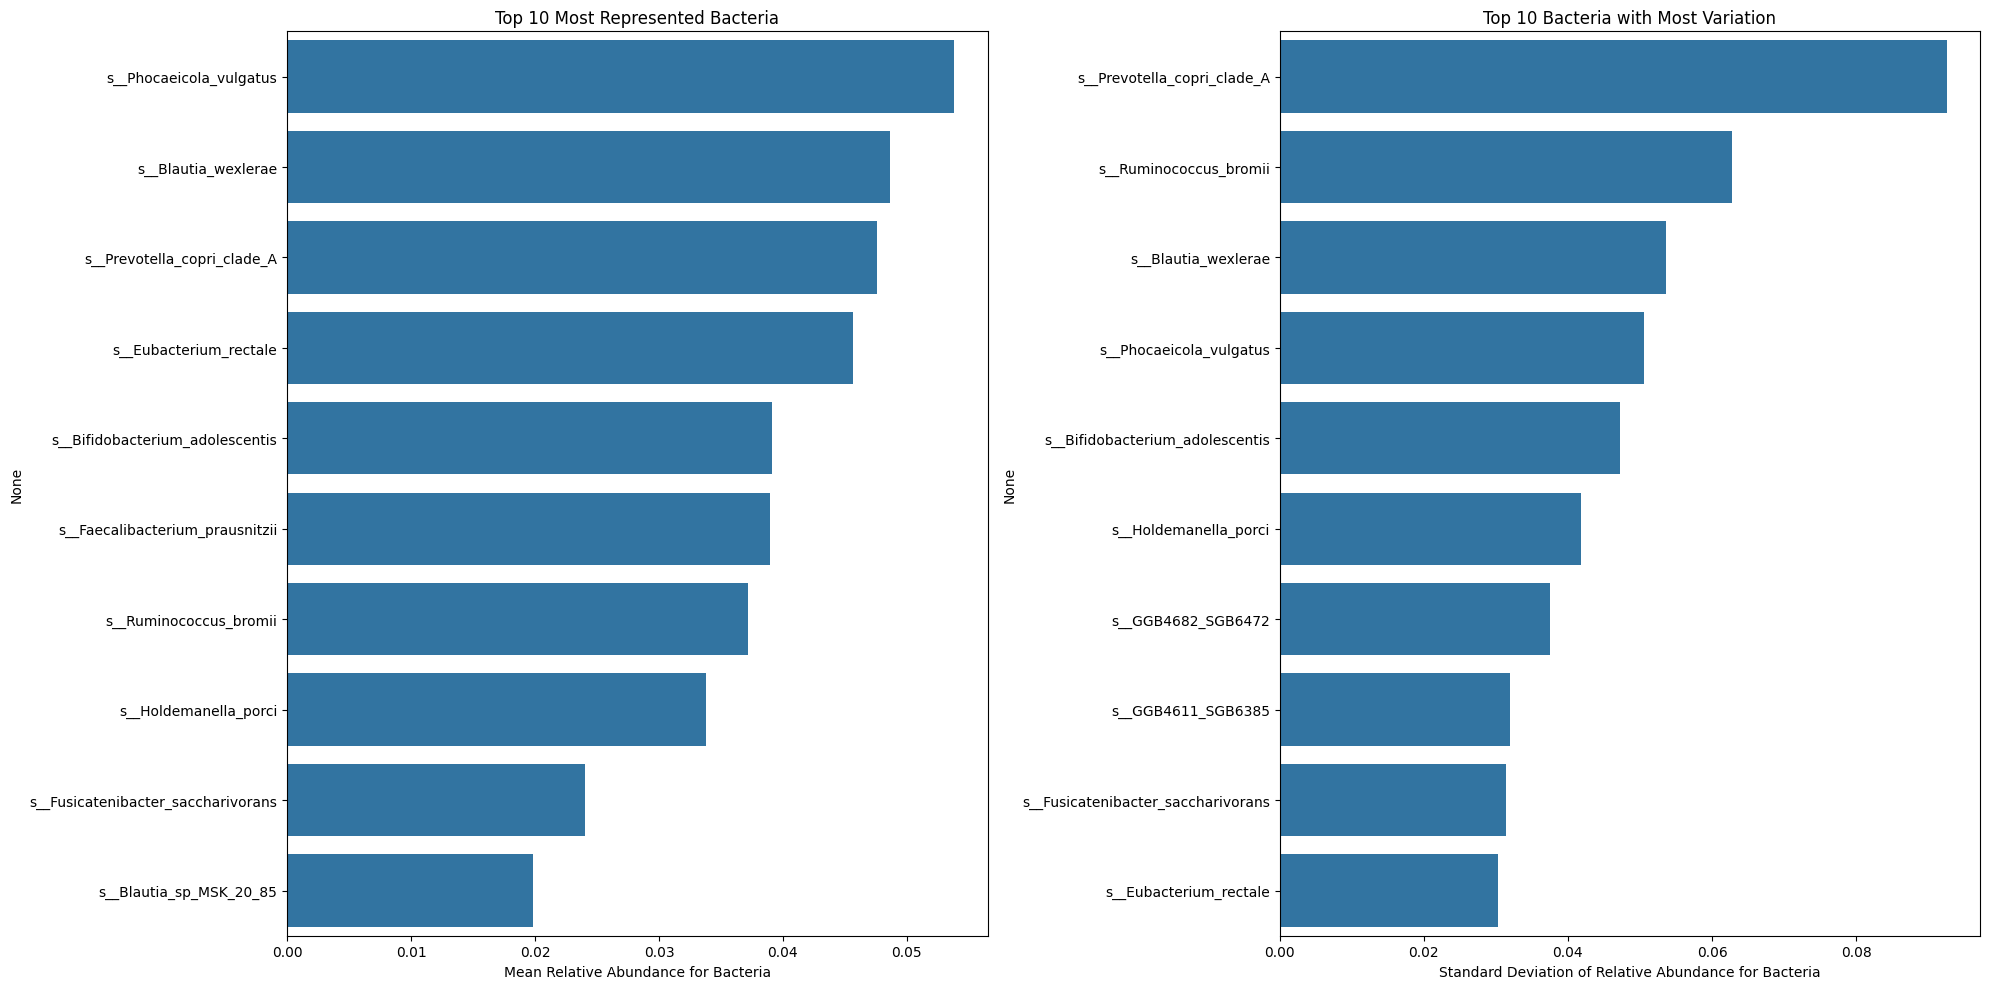

In [149]:
analyze_representation_and_variation(metaphlan_df, 2, 'Bacteria')

In [151]:
metaphlan_df.shape

(481, 1268)

In [ ]:
plot_alpha_diversity_over_time(metaphlan_df, smooth=False)